In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy import cos
from math import log
from scipy.interpolate import interp1d

Calculando $b$ e $\mu*M$ com parâmetros anteriores:

In [2]:
def lotkavolterra(t, z, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, I_M0, I_H0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T_curr - T1) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)

    print(f'b = {b_curr}')
    print(' ')
    print(f'mu = {mu_curr}')
    print(f'muM = {mu_curr * M}')
    
    #b = B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    #mu = -log(1 / (np.exp(-0.03 * T_curr ** 2 + 1.31 * T_curr - 4.4)))
    #M = 300000

    print(' ')
    print(f'p_ER = {p_ER(R_curr)}')
    print(f'p_LRT = {p_LRT(R_curr,T_curr)}')
    print(f'p_PR = {p_PR(R_curr)}')
    
    dShdt = -a_curr * b2 * (I_M0 / N) * S_H
    dIhdt = a_curr * b2 * (I_M0 / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H0 / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H0 / N) * S_M - mu_curr * E_M - a_curr * b1 * (I_H0 / N) * S_M * l_curr
    dImdt = a_curr * b1 * (I_H0 / N) * S_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [3]:
T1=27.4
T2=0.025
omega1=0.02
phi1=1.53

R1=146.9
R2=0.033
omega2=0.02
phi2=1.99

B_E=200 #FIXO, NÚMERO MÁXIMO DE OVOS POR OVIPOSIÇÃO
p_ME=0.9
p_ML=0.85
p_MP=0.85
tau_E=1
tau_P=1
c1= 0.019 #0.02
c2=-0.022 #0.15

D1=36.5
b1=0.1
b2=0.3

A= -0.03 #-0.03
B= 1.31 #1.31
C= -2 # -4.4

tau_H=10
DD=105
Tmin=14.5
gamma= 1/1095 #1/365
R_L = 200
N=8558

M= 300000 #100000
E_M0=50000 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

b = 10.026960568739408
 
mu = 0.08801387154981206
muM = 26404.16146494362
 
p_ER = 0.7183422345843472
p_LRT = 0.41184904005174133
p_PR = 0.6784343326629946
b = 10.026960147949346
 
mu = 0.08801387204935826
muM = 26404.16161480748
 
p_ER = 0.7183422245334461
p_LRT = 0.4118490327859362
p_PR = 0.6784343231704767
b = 10.026958355376703
 
mu = 0.08801387417743255
muM = 26404.162253229762
 
p_ER = 0.7183421817164368
p_LRT = 0.411849001833487
p_PR = 0.6784342827321903
b = 10.026957248694805
 
mu = 0.08801387549124297
muM = 26404.16264737289
 
p_ER = 0.7183421552824659
p_LRT = 0.4118489827243514
p_PR = 0.6784342577667732
b = 10.02695558867127
 
mu = 0.08801387746195867
muM = 26404.1632385876
 
p_ER = 0.7183421156314894
p_LRT = 0.4118489540606375
p_PR = 0.6784342203186288
b = 10.026948717181503
 
mu = 0.08801388561951821
muM = 26404.165685855463
 
p_ER = 0.7183419515004709
p_LRT = 0.41184883541027756
p_PR = 0.6784340653060001
b = 10.02694654237556
 
mu = 0.08801388820135889
muM = 26404.16646040

mu = 0.08688610603241356
muM = 26065.83180972407
 
p_ER = 0.7108234533955278
p_LRT = 0.4111008562322508
p_PR = 0.6713332615402205
b = 9.860442557561141
 
mu = 0.08677627068400552
muM = 26032.881205201655
 
p_ER = 0.7143830793939593
p_LRT = 0.4135324964764257
p_PR = 0.6746951305387393
b = 9.905946542340773
 
mu = 0.08674369238366055
muM = 26023.107715098162
 
p_ER = 0.7154824044684448
p_LRT = 0.41428057089515696
p_PR = 0.6757333819979755
b = 9.832363270718446
 
mu = 0.08679674704077311
muM = 26039.024112231935
 
p_ER = 0.7137030410954543
p_LRT = 0.4130690224543769
p_PR = 0.6740528721457067
b = 9.883427378302713
 
mu = 0.08675972087261061
muM = 26027.916261783183
 
p_ER = 0.7149387852231716
p_LRT = 0.41391082943948276
p_PR = 0.6752199638218841
b = 10.174103036790864
 
mu = 0.08656766398888188
muM = 25970.299196664564
 
p_ER = 0.72189365955772
p_LRT = 0.41860941561593085
p_PR = 0.6817884562489577
b = 10.132424731214245
 
mu = 0.08659313899186721
muM = 25977.941697560163
 
p_ER = 0.7209046

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 242
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff17c054d0>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
   

Modificando $R_1$ e $R_L$, usando dados do site https://pt.climate-data.org/america-do-sul/brasil/amazonas/manaus-1882/#google_vignette, que coloca a pluviosidade média anual como 3001 mm:

In [4]:
R1= 250.083 #146.9
R2= 0.033
omega2= 0.02
phi2=1.99

R_L = 350

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

b = 11.358154614860883
 
mu = 0.08801387154981206
muM = 26404.16146494362
 
p_ER = 0.7488202110545578
p_LRT = 0.4293230583506082
p_PR = 0.7072190882181935
b = 11.358154209086376
 
mu = 0.08801387204935826
muM = 26404.16161480748
 
p_ER = 0.748820202134879
p_LRT = 0.42932305166958773
p_PR = 0.7072190797940524
b = 11.358152480480202
 
mu = 0.08801387417743255
muM = 26404.162253229762
 
p_ER = 0.7488201641368963
p_LRT = 0.42932302320833066
p_PR = 0.7072190439070688
b = 11.358151413289308
 
mu = 0.08801387549124297
muM = 26404.16264737289
 
p_ER = 0.7488201406780515
p_LRT = 0.4293230056371843
p_PR = 0.707219021751493
b = 11.358149812502276
 
mu = 0.08801387746195867
muM = 26404.1632385876
 
p_ER = 0.7488201054897662
p_LRT = 0.42932297928045543
p_PR = 0.7072189885181125
b = 11.35814318621526
 
mu = 0.08801388561951821
muM = 26404.165685855463
 
p_ER = 0.7488199598315826
p_LRT = 0.4293228701796153
p_PR = 0.7072188509520502
b = 11.3581410890151
 
mu = 0.08801388820135889
muM = 26404.166460407

 
mu = 0.08822581693185427
muM = 26467.745079556284
 
p_ER = 0.7449389110028161
p_LRT = 0.4264431730214001
p_PR = 0.7035534159471041
b = 11.21543028137315
 
mu = 0.08818668180548561
muM = 26456.004541645685
 
p_ER = 0.7456702446882761
p_LRT = 0.4269818036115916
p_PR = 0.7042441199833719
b = 11.192629799797317
 
mu = 0.08821377451774064
muM = 26464.132355322192
 
p_ER = 0.7451646665176919
p_LRT = 0.426609252582282
p_PR = 0.7037666294889311
b = 11.054594438040994
 
mu = 0.08837495352064903
muM = 26512.48605619471
 
p_ER = 0.7420896681606653
p_LRT = 0.424361189166314
p_PR = 0.7008624643739617
b = 11.075416474308742
 
mu = 0.08835094605535718
muM = 26505.283816607152
 
p_ER = 0.7425550939262451
p_LRT = 0.42469954234313334
p_PR = 0.7013020331525648
b = 10.970370231926788
 
mu = 0.08847098254388003
muM = 26541.29476316401
 
p_ER = 0.7402012468896385
p_LRT = 0.4229950415816341
p_PR = 0.6990789553957697
b = 10.91141732273585
 
mu = 0.08853717988023335
muM = 26561.153964070007
 
p_ER = 0.738873

b = 9.21367778365707
 
mu = 0.08984924441960601
muM = 26954.773325881804
 
p_ER = 0.698416081858219
p_LRT = 0.395485297277115
p_PR = 0.6596151884216512
b = 9.187484667424828
 
mu = 0.08983546659401839
muM = 26950.63997820552
 
p_ER = 0.6977529464149589
p_LRT = 0.3951439866257877
p_PR = 0.65898889383635
b = 9.115139139243453
 
mu = 0.08965487788320302
muM = 26896.463364960906
 
p_ER = 0.6959082249315434
p_LRT = 0.3945499192658802
p_PR = 0.657246656879791
b = 9.129164467527414
 
mu = 0.08951212817222819
muM = 26853.638451668456
 
p_ER = 0.696258835139483
p_LRT = 0.39510987961502664
p_PR = 0.657577788742845
b = 9.132250109838502
 
mu = 0.08949630997610232
muM = 26848.892992830697
 
p_ER = 0.6963366215402188
p_LRT = 0.3951943148275276
p_PR = 0.6576512536768734
b = 9.137447931141578
 
mu = 0.08947202093951533
muM = 26841.606281854598
 
p_ER = 0.6964677226793812
p_LRT = 0.39533070625117367
p_PR = 0.6577750714194155
b = 9.166180947751776
 
mu = 0.08936461396776975
muM = 26809.384190330926
 
p

p_ER = 0.7661624901259289
p_LRT = 0.4432429409876993
p_PR = 0.723597907341155
b = 12.125734428969919
 
mu = 0.08692139572945924
muM = 26076.418718837773
 
p_ER = 0.7653553954863379
p_LRT = 0.4425117995892999
p_PR = 0.7228356512926525
b = 12.1848310599179
 
mu = 0.0868055939560787
muM = 26041.67818682361
 
p_ER = 0.7666039975313853
p_LRT = 0.4436540953398484
p_PR = 0.7240148865574195
b = 12.14530181741019
 
mu = 0.08688463091058732
muM = 26065.389273176195
 
p_ER = 0.7657690748194061
p_LRT = 0.44288369143162815
p_PR = 0.7232263484405502
b = 11.78847472395195
 
mu = 0.08745069540195419
muM = 26235.208620586258
 
p_ER = 0.7581695793929394
p_LRT = 0.43652401254727546
p_PR = 0.7160490472044427
b = 11.853893408997243
 
mu = 0.08735720660609293
muM = 26207.16198182788
 
p_ER = 0.759572488431476
p_LRT = 0.437648459339131
p_PR = 0.7173740168519496
b = 11.490300137100048
 
mu = 0.08784847520662642
muM = 26354.542561987924
 
p_ER = 0.751714408261337
p_LRT = 0.43150755692701065
p_PR = 0.7099524966

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 242
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff1b7b6f50>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
   

Printando parâmetros de $T(0)$, $T_{curr}$ e $a$

In [5]:
def lotkavolterra(t, z, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, I_M0, I_H0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T_curr - T1) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)

    #print(f'muM = {mu_curr * M}')

    t=0
    print(Temp(t))
    print(T_curr)
    print(a(Temp(t)))
    print(a(T_curr))
    print(' ')
    
    dShdt = -a_curr * b2 * (I_M0 / N) * S_H
    dIhdt = a_curr * b2 * (I_M0 / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H0 / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H0 / N) * S_M - mu_curr * E_M - a_curr * b1 * (I_H0 / N) * S_M * l_curr
    dImdt = a_curr * b1 * (I_H0 / N) * S_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [6]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

27.427937732700485
27.427937732700485
0.000765417334259907
0.000765417334259907
 
27.427937732700485
27.427937924811694
0.0007654225975806938
0.0007654225975806938
 
27.427937732700485
27.427938743208337
0.0007654450194065266
0.0007654450194065266
 
27.427937732700485
27.42793924846224
0.0007654588619792525
0.0007654588619792525
 
27.427937732700485
27.42794000634306
0.0007654796258373193
0.0007654796258373193
 
27.427937732700485
27.42794314350525
0.0007655655754863246
0.0007655655754863246
 
27.427937732700485
27.42794413640624
0.0007655927782531703
0.0007655927782531703
 
27.427937732700485
27.427942535480028
0.0007655489172610839
0.0007655489172610839
 
27.427937732700485
27.427943643813578
0.0007655792825638067
0.0007655792825638067
 
27.427937732700485
27.427950244554054
0.0007657601247686524
0.0007657601247686524
 
27.427937732700485
27.427949259369075
0.0007657331333993667
0.0007657331333993667
 
27.427937732700485
27.42795419936747
0.0007658684758211296
0.0007658684758211296
 

-0.0011969129092125558
-0.0011969129092125558
 
27.427937732700485
27.68180059978685
0.007720564377721967
0.007720564377721967
 
27.427937732700485
27.647563808606463
0.0067825700988072566
0.0067825700988072566
 
27.427937732700485
27.438766138895982
0.0010620859971502317
0.0010620859971502317
 
27.427937732700485
27.336513387050438
-0.0017393592588920712
-0.0017393592588920712
 
27.427937732700485
27.326632714914584
-0.002010062605079839
-0.002010062605079839
 
27.427937732700485
27.311841264955525
-0.002415307809437623
-0.002415307809437623
 
27.427937732700485
27.251134618532895
-0.004078503601838463
-0.004078503601838463
 
27.427937732700485
27.232149186333736
-0.004598652429212681
-0.004598652429212681
 
27.427937732700485
27.262821404478924
-0.003758317685508896
-0.003758317685508896
 
27.427937732700485
27.241552067823232
-0.0043410392377196344
-0.0043410392377196344
 
27.427937732700485
27.118923590643227
-0.00770072354402113
-0.00770072354402113
 
27.427937732700485
27.1366915

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 242
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff1b7f4ed0>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
   

Printando parâmetros de $T(0)$, $T_{curr}$ e $\mu$

In [7]:
def lotkavolterra(t, z, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, I_M0, I_H0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    

    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T_curr - T1) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)

    #print(f'muM = {mu_curr * M}')
    
    print(t)
    print(Temp(t))
    print(mu(Temp(t)))
    print(' ')
    
    dShdt = -a_curr * b2 * (I_M0 / N) * S_H
    dIhdt = a_curr * b2 * (I_M0 / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H0 / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H0 / N) * S_M - mu_curr * E_M - a_curr * b1 * (I_H0 / N) * S_M * l_curr
    dImdt = a_curr * b1 * (I_H0 / N) * S_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt]

In [8]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

0.0
27.427937732700485
0.08801387154981206
 
1.40343933816894e-05
27.427937924811694
0.08801387204935826
 
7.382112245259866e-05
27.427938743208337
0.08801387417743255
 
0.00011073168367889801
27.42793924846224
0.08801387549124297
 
0.000166097525518347
27.42794000634306
0.08801387746195867
 
0.00039527820974922905
27.42794314350525
0.08801388561951821
 
0.00046781311272298
27.42794413640624
0.08801388820135889
 
0.00035085983454223504
27.427942535480028
0.0880138840384704
 
0.0004318274886673662
27.427943643813578
0.08801388692047005
 
0.0009140348510125918
27.427950244554054
0.08801390408439043
 
0.000842063602901364
27.427949259369075
0.08801390152261002
 
0.0012029480041448057
27.42795419936747
0.08801391436811362
 
0.0014034393381689401
27.427956943810397
0.08801392150450953
 
0.0014034393381689401
27.427956943810397
0.08801392150450953
 
0.00014034393381689403
27.42793965381247
0.08801387654527414
 
0.00028068786763378806
27.42794157492423
0.08801388154073794
 
0.0010915639296869

181.8543121794308
27.049999051408548
0.08707444858117007
 
185.79155793330034
27.004763924397267
0.08696769517779039
 
185.79155793330034
27.004763924397267
0.08696769517779039
 
160.98690968392216
27.318716792511566
0.08773353276113657
 
163.74298171163085
27.281367812403754
0.08763933931987132
 
179.66695342728104
27.07608548238448
0.08713655472303707
 
187.2921805668023
26.98815318730819
0.08692879295445302
 
188.04249188355328
26.97998599987362
0.0869097240779483
 
189.16795885867973
26.967913124841843
0.08688160679483248
 
193.82670300252767
26.920333588124993
0.08677161380263539
 
195.3011795954726
26.906123121095092
0.08673901463599033
 
192.92377417992955
26.92924240804087
0.08679210990268568
 
194.569670236844
26.913120223545473
0.0867550517059192
 
204.3718956424677
26.828587700343718
0.08656317605069568
 
202.90887692521042
26.83988451900723
0.08658858283108234
 
210.2448707788862
26.788253832701372
0.08647305301506758
 
214.32042291981716
26.765190470076945
0.08642193153609

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 242
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff1b828ad0>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
   

É possível verificar que, diferente dos valores obtidos pelo t_eval, o valor de t não está atuaizando corretamente na função, até mesmo voltando para um valor "passado". É necessário verificar se isso está afetando incorretamente o código

In [9]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 365)  # Avalia a solução em 365 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

0.0
27.427937732700485
0.08801387154981206
 
1.40343933816894e-05
27.427937924811694
0.08801387204935826
 
7.382112245259866e-05
27.427938743208337
0.08801387417743255
 
0.00011073168367889801
27.42793924846224
0.08801387549124297
 
0.000166097525518347
27.42794000634306
0.08801387746195867
 
0.00039527820974922905
27.42794314350525
0.08801388561951821
 
0.00046781311272298
27.42794413640624
0.08801388820135889
 
0.00035085983454223504
27.427942535480028
0.0880138840384704
 
0.0004318274886673662
27.427943643813578
0.08801388692047005
 
0.0009140348510125918
27.427950244554054
0.08801390408439043
 
0.000842063602901364
27.427949259369075
0.08801390152261002
 
0.0012029480041448057
27.42795419936747
0.08801391436811362
 
0.0014034393381689401
27.427956943810397
0.08801392150450953
 
0.0014034393381689401
27.427956943810397
0.08801392150450953
 
0.00014034393381689403
27.42793965381247
0.08801387654527414
 
0.00028068786763378806
27.42794157492423
0.08801388154073794
 
0.0010915639296869

27.07608548238448
0.08713655472303707
 
187.2921805668023
26.98815318730819
0.08692879295445302
 
188.04249188355328
26.97998599987362
0.0869097240779483
 
189.16795885867973
26.967913124841843
0.08688160679483248
 
193.82670300252767
26.920333588124993
0.08677161380263539
 
195.3011795954726
26.906123121095092
0.08673901463599033
 
192.92377417992955
26.92924240804087
0.08679210990268568
 
194.569670236844
26.913120223545473
0.0867550517059192
 
204.3718956424677
26.828587700343718
0.08656317605069568
 
202.90887692521042
26.83988451900723
0.08658858283108234
 
210.2448707788862
26.788253832701372
0.08647305301506758
 
214.32042291981716
26.765190470076945
0.0864219315360925
 
214.32042291981716
26.765190470076945
0.0864219315360925
 
188.64444443195202
26.973501997231896
0.08689461260294609
 
191.4973309306037
26.943628193717334
0.08682530283614326
 
207.98067514503566
26.80283301348061
0.08650552315411184
 
216.75203999907703
26.753429204846356
0.0863959768895716
 
217.9678485387069

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 242
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff1b77fe50>
   status: 0
  success: True
        t: array([  0.        ,   1.00274725,   2.00549451,   3.00824176,
         4.01098901,   5.01373626,   6.01648352,   7.01923077,
         8.02197802,   9.02472527,  10.02747253,  11.03021978,
        12.03296703,  13.03571429,  14.03846154,  15.04120879,
        16.04395604,  17.0467033 ,  18.04945055,  19.0521978 ,
        20.05494505,  21.05769231,  22.06043956,  23.06318681,
        24.06593407,  25.06868132,  26.07142857,  27.07417582,
        28.07692308,  29.07967033,  30.08241758,  31.08516484,
        32.08791209,  33.09065934,  34.09340659,  35.09615385,
        36.0989011 ,  37.10164835,  38.1043956 ,  39.10714286,
        40.10989011,  41.11263736,  42.11538462,  43.11813187,
        44.12087912,  45.12362637,  46.12637363,  47.12912088,
   

In [10]:
times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

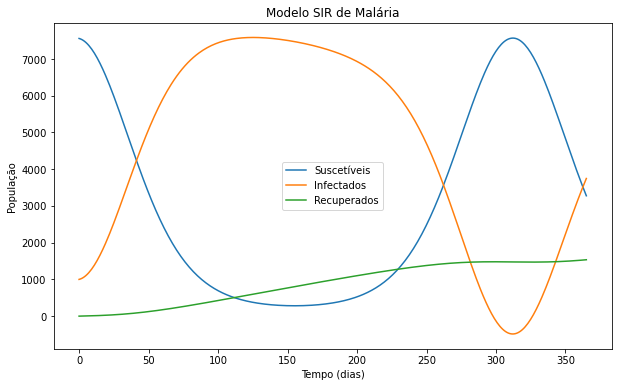

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

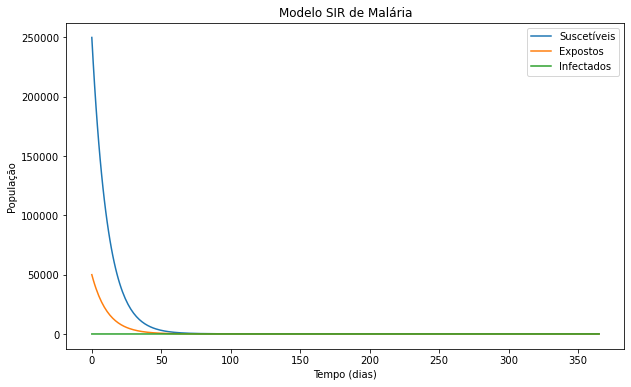

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()